# Code Notebook 3: Classification #

In this notebook, I use Random Forest and Logistic Regression models to look for erroneous words the models consider important.  Such words could make good stop words.  I then evaluate several models and provide my conclusions and Recommendations.

In [1]:
import pandas as pd

import pickle

import metrictools as mt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
corpus = pd.read_csv('../data/corpus.csv')

In [3]:
X = corpus['body']
y = corpus['subreddit'].map({'Futurology':0, 'science':1})

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=4835)

### Section 8: Stop Word Selection With Random Forests and Logistic Regression ###

In this section, I will be running random forest and logistic regression models and identifying words that receive a lot of weight by the model but are likely not very generalizable to new data.  I will add these to the existing stop words list I have from my NLP EDA in Part 2.

In [4]:
def token_lem(in_str):
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    tokenized = tokenizer.tokenize(in_str)
    lemmatized = [lemmatizer.lemmatize(token.lower()) for token in tokenized if len(token) > 1]
    return lemmatized

In [5]:
stop_words = ['the', 'to', 'and', 'of', 'it', 'that', 'is', 'in', 'you', 'for', 'are', 'be', 'not', 'this', 'but',
             'we', 'they', 'on', 'have', 'with', 'can', 'a', 'if', 'or', 'just', 'people', 'would', 'so', 'like',
             'more', 'all', 'there', 'at', 'what', 'from', 'about', 'do', 'an', 'wa', 'by', 'don', 'one', 'get',
             'how', 'their', 'no', 'than', 'your', 're', 'ha', 'think', 'out', 'because', 'thing', 'even', 'my',
             'will', 'year', 'up', 'make', 'need', 'them', 'when', 'could', 'some', 'only', 'much', 'gt', 'which',
             'way', 'also', 'then', 'other', 'now', 'who', 'http', 'being', 'know', 'why', 'good', 'most', 'any',
             'still', 'see', 'really', 'should', 'me', 'these', 'he', 'time', 'u', 'our', 'into', 'going', 'go',
             'want', 'work', 'use', 'been', 'well', 'those', 'take', 'where', 'point', 'mean', 'very', 'lot',
             'problem', 'over', 'here', 'say', 'something', 'right', 'doesn', 'many', 'same', 'isn',
             'too', 'were', 've', 'actually', 'every', 'le', 'had', 'used', 'www', 'sure']

In [6]:
pipe = Pipeline([
    ('tf_vec', TfidfVectorizer(tokenizer=token_lem, min_df=5, stop_words=stop_words)),
    ('forest', RandomForestClassifier(n_jobs=-1))
])

In [7]:
pipe_params = {
    'tf_vec__ngram_range' : [(1,1), (1,2)],
    'tf_vec__max_features' : [10_000],
    'forest__ccp_alpha' : [0.0],
    'forest__max_depth' : [10],
    'forest__n_estimators' : [400]
}

Through experimentation, I found that inclusion of bigrams tends to make very little difference in predictive power for classifying these subreddits.  Also through experimentation, I settled on the above values of ccp_alpha, max_depth, and n_estimators as reasonable choices for this process of identifying stop words.  They result in minimal overfitting and some of the best scores random forests have produced in this analysis.

Random_state was not set here to avoid fitting my stop words to a specific random state.

In [8]:
gs = GridSearchCV(pipe, pipe_params, scoring='f1', cv=5)

In [9]:
gs.fit(X_train, y_train);

In [10]:
gs.best_params_

{'forest__ccp_alpha': 0.0,
 'forest__max_depth': 10,
 'forest__n_estimators': 400,
 'tf_vec__max_features': 10000,
 'tf_vec__ngram_range': (1, 1)}

In [11]:
pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_forest__ccp_alpha,param_forest__max_depth,param_forest__n_estimators,param_tf_vec__max_features,param_tf_vec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.684752,0.746359,1.004829,0.030679,0.0,10,400,10000,"(1, 1)","{'forest__ccp_alpha': 0.0, 'forest__max_depth'...",0.789796,0.785393,0.791010,0.789198,0.796888,0.790457,0.003724,1
1,5.512799,0.042233,1.076014,0.013122,0.0,10,400,10000,"(1, 2)","{'forest__ccp_alpha': 0.0, 'forest__max_depth'...",0.790362,0.786665,0.787739,0.790992,0.793570,0.789866,0.002450,2


In [12]:
gs.score(X_train, y_train)

0.8011782749470506

In [13]:
gs.score(X_test, y_test)

0.791657142857143

In [14]:
importances = pd.DataFrame(zip(gs.best_estimator_[0].vocabulary_, gs.best_estimator_[1].feature_importances_), columns = ['word', 'importance'])
importances.sort_values(by='importance', ascending=False)[0:5]

,word,importance
8353,san,0.031954
8303,asphalt,0.029455
2228,implement,0.025447
8625,enables,0.024814
3197,70,0.022135


I have found very few words that are highly rated by this algorithm and are clearly bad choices.  The current top 5 are shown above to avoid a very long list, but most words in the top 100 or so seem like they could legitimately be important.

Below, I check the logistic regression coefficients to see if logistic regression is giving high importance to any stop words.

In [15]:
pipe = Pipeline([
    ('tf_vec', TfidfVectorizer(tokenizer=token_lem, min_df=5, stop_words=stop_words)),
    ('logreg', LogisticRegression(n_jobs=-1, solver='saga', max_iter=10_000))
])

In [16]:
pipe_params = {
    'tf_vec__ngram_range' : [(1,1), (1,2)],
    'tf_vec__max_features' : [10_000],
    'logreg__C' : [1],
    'logreg__penalty' : ['l2']
}

Logistic regression parameters chosen for this process are mostly the defaults.  I am using the saga solver because it will allow me to later Gridsearch over all regularization methods.  Also, the documentation indicates that saga is a good choice for large datasets.

In [17]:
gs = GridSearchCV(pipe, pipe_params, scoring='f1', cv=5)

In [18]:
gs.fit(X_train, y_train);

In [19]:
gs.best_params_

{'logreg__C': 1,
 'logreg__penalty': 'l2',
 'tf_vec__max_features': 10000,
 'tf_vec__ngram_range': (1, 2)}

In [20]:
pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_logreg__penalty,param_tf_vec__max_features,param_tf_vec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,5.015736,0.009735,0.997755,0.007100,1,l2,10000,"(1, 2)","{'logreg__C': 1, 'logreg__penalty': 'l2', 'tf_...",0.832162,0.823948,0.829261,0.833662,0.834056,0.830618,0.003736,1
0,3.868643,0.017840,0.922669,0.013044,1,l2,10000,"(1, 1)","{'logreg__C': 1, 'logreg__penalty': 'l2', 'tf_...",0.831103,0.823062,0.829823,0.832373,0.835507,0.830374,0.004115,2


In [21]:
gs.score(X_train, y_train)

0.880370349460848

In [22]:
gs.score(X_test, y_test)

0.8323365100230036

In [23]:
importances = pd.DataFrame(zip(gs.best_estimator_[0].vocabulary_, gs.best_estimator_[1].coef_[0]), columns = ['word', 'importance'])
importances.sort_values(by='importance', ascending=False)[0:5]

,word,importance
8657,1930s,5.873823
9490,after month,5.735986
2249,beat,5.732212
2079,parked,4.691416
2061,lesson,4.618477


In [24]:
importances.sort_values(by='importance', ascending=True)[:5]

,word,importance
5419,sciencedaily,-6.103375
488,shop,-5.949594
8111,bos,-5.766675
8324,compose 2fr,-5.733085
8392,median age,-5.304551


For the most part, I'm finding that adding stopwords isn't helping with these subreddits.  Stopwords may be more useful if the posts were more spread out in time, because some topics will change over time.  In this case, however, most stopwords I add make the model perform worse on the test data, so I am only using the stopwords identified during EDA.

### Section 9: Model Transformation, Fitting, and Evaluation ###

*The script "run_models.py," in this folder, was used to fit and pickle models for this step of the project.*

Note about vectorizer and models used in this project:  There is a very wide range of choices for lemmatizing and vectorizing NLP data, and this dataset was quite large.  Some decisions were necessary to narrow down the processing, vectorizing, and classification strategies a priori.  I decided to use a simple RegEx tokenizer and lemmatizer to give myself control and transparency.  For the vectorizer, I considered CountVectorizer, TfidfVectorizer, and Word2Vec.  I thought the weighting based on document frequency provided by TfidfVectorizer could be useful, but that many posts would be too short for Word2Vec to develop appropriate similarity scores.  In retrospect, I think Word2Vec would be interesting to try.  Would it improve results by identifying similar words, or is word choice itself an important feature?  For models, I tried every classifier covered so far except decision trees and bagged decision trees, which are less sophisticated versions of Adaboost and Random Forest, and k-neighbors.  It would be interesting to try k-neighbors and some of the other boosting methods.

Below, pickles for each model were imported and evaluated after they were fit and stored using the script indicated above.

The pickle filename currently is bayes_1, which I believe was the most successful model, as discussed below in conclusions.  Other models can easily be tested by running the import and train/test/split cells at the top of this workbook, then replacing 'bayes_1.p' with any of the other filenames in the pickles folder.

For evaluation purposes, the baseline score is 50%, since I included exactly 25,000 comments from each subreddit in these models.

In [25]:
pickle_filename = 'bayes_1.p'

In [26]:
with open(f'../pickles/{pickle_filename}', mode='rb') as pickle_in:
    estimator = pickle.load(pickle_in)

In [27]:
pd.DataFrame(estimator.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bayes__alpha,param_bayes__fit_prior,param_tf_vec__max_features,param_tf_vec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.906853,0.299514,0.951716,0.020283,0.5,True,10000,"(1, 1)","{'bayes__alpha': 0.5, 'bayes__fit_prior': True...",0.837726,0.828862,0.832435,0.835863,0.838902,0.834758,0.003670,1
2,3.761538,0.015278,0.941291,0.012963,0.5,False,10000,"(1, 1)","{'bayes__alpha': 0.5, 'bayes__fit_prior': Fals...",0.837726,0.828862,0.832435,0.835863,0.838902,0.834758,0.003670,1
4,3.734395,0.019025,0.933607,0.016645,1,True,10000,"(1, 1)","{'bayes__alpha': 1, 'bayes__fit_prior': True, ...",0.836260,0.827735,0.833097,0.834328,0.838829,0.834050,0.003704,3
6,3.751716,0.016619,0.941172,0.009699,1,False,10000,"(1, 1)","{'bayes__alpha': 1, 'bayes__fit_prior': False,...",0.836260,0.827735,0.833097,0.834328,0.838829,0.834050,0.003704,3
8,3.780761,0.033474,0.936764,0.010583,2,True,10000,"(1, 1)","{'bayes__alpha': 2, 'bayes__fit_prior': True, ...",0.834691,0.828637,0.831725,0.833238,0.835770,0.832812,0.002493,5
10,3.737767,0.022840,0.939123,0.010084,2,False,10000,"(1, 1)","{'bayes__alpha': 2, 'bayes__fit_prior': False,...",0.834691,0.828637,0.831725,0.833238,0.835770,0.832812,0.002493,5
5,5.269505,0.021542,1.057511,0.012652,1,True,10000,"(1, 2)","{'bayes__alpha': 1, 'bayes__fit_prior': True, ...",0.831979,0.819822,0.822512,0.826512,0.831664,0.826498,0.004841,7
7,5.262183,0.046336,1.063985,0.014854,1,False,10000,"(1, 2)","{'bayes__alpha': 1, 'bayes__fit_prior': False,...",0.831979,0.819822,0.822512,0.826512,0.831664,0.826498,0.004841,7
1,5.295988,0.062088,1.070553,0.029814,0.5,True,10000,"(1, 2)","{'bayes__alpha': 0.5, 'bayes__fit_prior': True...",0.830928,0.817374,0.823696,0.826210,0.833663,0.826374,0.005693,9
3,5.331939,0.061727,1.075088,0.026060,0.5,False,10000,"(1, 2)","{'bayes__alpha': 0.5, 'bayes__fit_prior': Fals...",0.830928,0.817374,0.823696,0.826210,0.833663,0.826374,0.005693,9


Train Data Metrics:

              precision    recall  f1-score   support

  Futurology     0.8699    0.8620    0.8659     17500
     Science     0.8632    0.8711    0.8671     17500

    accuracy                         0.8665     35000
   macro avg     0.8666    0.8665    0.8665     35000
weighted avg     0.8666    0.8665    0.8665     35000

ROC AUC score: 0.8665428571428572

*************************

Test Data Metrics:

              precision    recall  f1-score   support

  Futurology     0.8381    0.8309    0.8345      7500
     Science     0.8324    0.8395    0.8359      7500

    accuracy                         0.8352     15000
   macro avg     0.8352    0.8352    0.8352     15000
weighted avg     0.8352    0.8352    0.8352     15000

ROC AUC score: 0.8351999999999999

*************************

CPU times: user 6.72 s, sys: 18.6 ms, total: 6.74 s
Wall time: 6.74 s


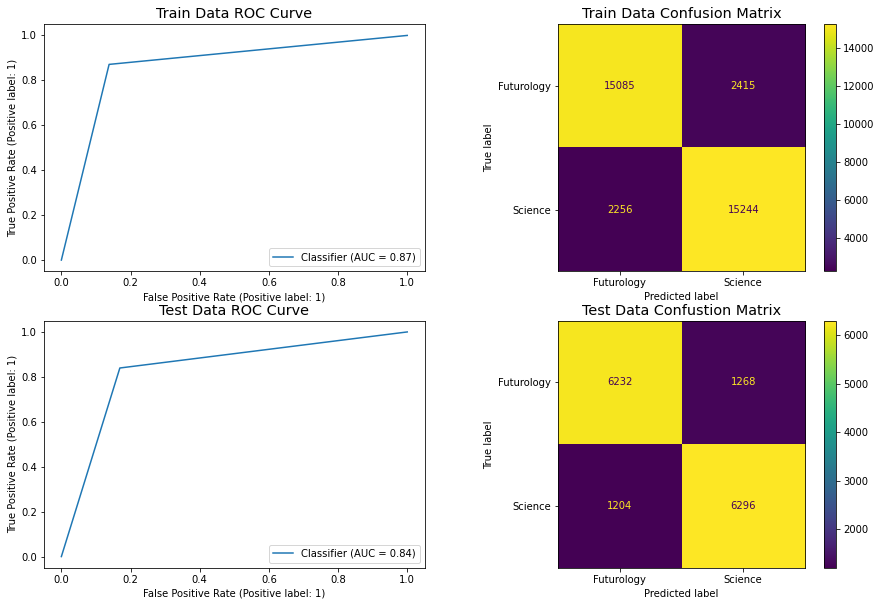

In [28]:
%%time
mt.check_metrics(estimator, X_train, X_test, y_train, y_test)

Multinomial Naive Bayes was one of the most successful models, maxing out an F1 score of nearly 83.5% on the test data.  It was slightly overfit, with a train score of 86.7%.  At the same time, it was one of the quickest algorithms, completing 8 models with 5-fold cross-validation on 50,000 rows of data with 10,000 features in just over 5 minutes.  Overall, Naive Bayes scores were very consistent, and none of hyperparameters tested lowered its score more than about 5%.  Only max features affected the score by more than about 1%.  More max features continued to produce improvements at all levels tested: 1000, 3000, 5000, and 10000.

Random forest was one of the weakest models, maxing out at 79.8% F1 score.  The most successful random forests were very highly overfit, scoring nearly 100% on the test data despite cross-validation during the fitting process.  Hyperparameter tuning only resulted in a few percentage points difference in F1 score.  Forcing the model to limit max depth resulted in less overfitting but did not improve scores on the test data.

Adaboost had very similar scores to random forests, reaching 80.7% F1 score.  It stood out from the other models in a few ways, however.  Its score was severely hurt by too high a learning rate.  It also performed best with bigrams and stop words, unlike the other models, although these still made very little difference to the F1 score.  Adaboost was also not overfit, with very similar train and test scores.  Limiting max features to 1,000 hurt its performance somewhat.

Logistic regression outperformed the decision tree methods, but it fell just short of Multinomial Naive Bayes, with an F1 score of 83.2% (achieved in the stop words selection section above, not in the pickled models - evidence that more gridsearching could lead to further improvement).  It was somewhat overfit, scoring 88% on the test data.  Ridge regression outperformed lasso regression significantly.  Limiting max features to 1000 also harmed the model.

Support vector classifier stood by taking significantly longer than other models to fit.  It did slightly edge out Multinomial Naive Bayes for best score on the test data, but the scores were so close that they both rounded to 83.5%.  SVC was also more dependent on hyperparameters than Naive Bayes and very heavily overfit, with nearly 100% F1 score on the train data.

Altogether, I consider Multinomial Naive Bayes to be the most successful of the models used here, due to essentially typing SVC for best score on the test data, showing little reliance on hyperparameters, and being among the quickest models to fit.

We can see that all of these models yielded similar results on the test data with appropriate hyperparameters.  The difference between the best and worst models was less than 5%, and most hyperparameters tested only affected F1 score by a few percentage points.  The most significant hyperparameter was max features, which produced improvement up to at least 10,000.

A successful prediction rate of 83.5% is not bad, considering the wide variety of commenters on reddit.  Many comments are short and contain few keywords that would help a human to predict which subreddit they came from.  I would be surprised if most people could beat this score with these two subreddits.

### Section 10: Conclusions and Recommendations ###

Based on the observations made during EDA, there are significat differences between the Science and Futurology subreddits.  The top words suggest that Futurology posts are more focused on specific topics having to do with future hopes and goals, while Science posts are marked by references to sources and current problems and issues.

The classification algorithms used were able to classify comments with a success rate of a little over 83%, as measured by F1 score, not bad considering that no comments were filtered out other than moderator bots and rules comments.  This emphasizes that there is a substantive difference between the subreddits, and suggests that machine learning algorithms can help us understand those differences.

There are a few possible future directions for this work:
- Broaden the timeframe of the posts:  These posts came from a timeframe of only one or two weeks.  Sampling a wider time frame could reduce the dependence of the models on terms related to current events, possibly reducing both performance and overfitting.  On the other hand, posts from a wider time frame may improve performance.  With sufficent time or computing power, many more posts could be included.  It would be interesting to see how this affected the model.
- Consider adding in the score or sentiment features to weight posts.  Although these did not look like they would make a large difference when examined in the EDA section, they may make some difference if handled properly.
- Continue grid search options, especially for models that were overfit.  Although model quality appears to have reached a maximum for this data, there is more hyperparameter tuning that could be done with additional time or computing power.